## Подключаем необходимые модули

In [1]:
# !pip install tensorflow_addons

                                              0.0/736.6 kB ? eta -:--:--
     -                                       30.7/736.6 kB 1.3 MB/s eta 0:00:01
     --                                    41.0/736.6 kB 388.9 kB/s eta 0:00:02
     ----                                  92.2/736.6 kB 655.4 kB/s eta 0:00:01
     ----                                  92.2/736.6 kB 655.4 kB/s eta 0:00:01
     --------                             174.1/736.6 kB 803.1 kB/s eta 0:00:01
     -----------                          235.5/736.6 kB 901.1 kB/s eta 0:00:01
     -----------------                      337.9/736.6 kB 1.0 MB/s eta 0:00:01
     ----------------------                 430.1/736.6 kB 1.2 MB/s eta 0:00:01
     ------------------------               481.3/736.6 kB 1.2 MB/s eta 0:00:01
     -----------------------------          573.4/736.6 kB 1.2 MB/s eta 0:00:01
     ----------------------------------     675.8/736.6 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 736


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# !git clone https://github.com/lyftzeigen/SemanticSegmentationLesson.git

In [1]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from skimage import measure
from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.morphology import dilation, disk
from skimage.draw import polygon, polygon_perimeter

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.config.list_physical_devices("GPU") else "OFF" }')

c:\Users\mi28d\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Tensorflow version 2.12.0
GPU is OFF


## Подготовим набор данных для обучения

In [3]:
CLASSES = 4

COLORS = ['red', 'lime',
          'blue', 'orange']

# (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)

SAMPLE_SIZE = (512, 512)

OUTPUT_SIZE = (512, 512)

In [4]:
def load_images(image, mask):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
    
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask)
    mask = tf.image.rgb_to_grayscale(mask)
    mask = tf.image.resize(mask, OUTPUT_SIZE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    masks = []
    
    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))
    
    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))

    return image, masks

def augmentate_images(image, masks):   
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)
    
    random_flip = tf.random.uniform((), 0, 1)    
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    
    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)
    
    return image, masks

Переименновка

In [4]:
# import os 

# list_dir = ['./img', 
#             './masks_machine']
# # new_list_dir = ['./new_img', './new_masks']
# name_file = ['i', 'm']


# for i in range(len(list_dir)):
#     for temp, f in enumerate(os.listdir(f"{list_dir[i]}")):
#         os.rename(f"{list_dir[i]}/{f}", f"{list_dir[i]}/{name_file[i]}{temp}.{f[-3:]}")

FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: './img/i10.JPG' -> './img/i2.JPG'

In [5]:
images = sorted(glob.glob('./img/*.JPG'))
masks = sorted(glob.glob('./masks/*.png'))

print(len(images))

images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_dataset = tf.data.Dataset.from_tensor_slices(masks)

dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))

dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.repeat(60)
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)

50


## Посмотрим на содержимое набора данных

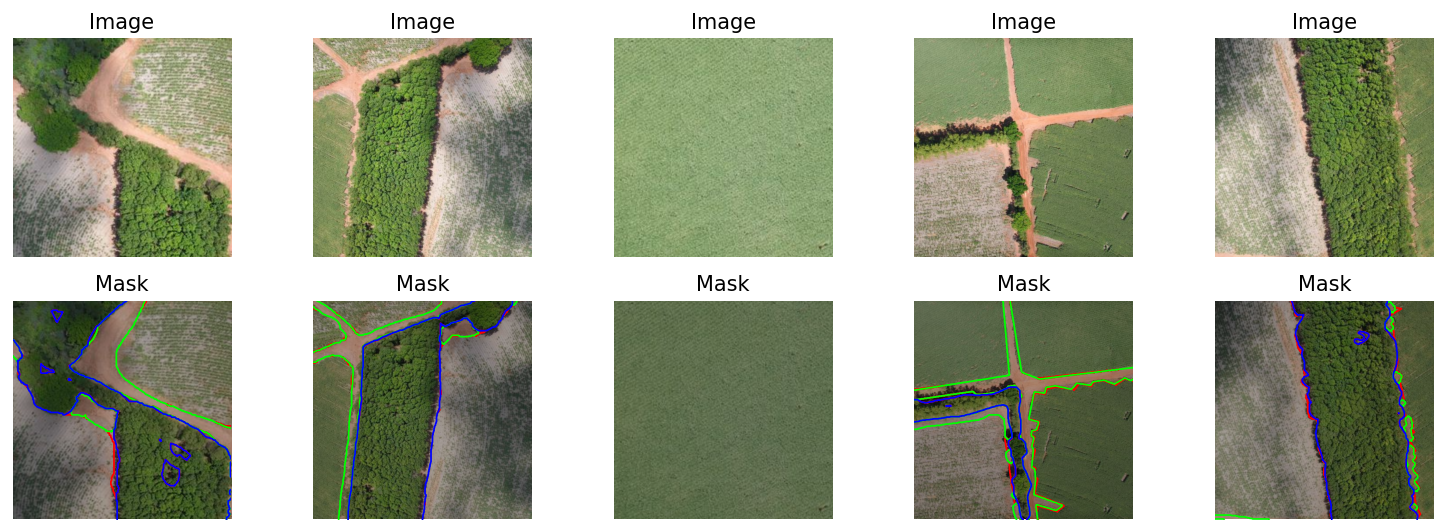

In [6]:
images_and_masks = list(dataset.take(5))

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(15, 5), dpi=125)

for i, (image, masks) in enumerate(images_and_masks):
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)
        
    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()    
    ax[1, i].imshow(image/1.5)
   
    for channel in range(CLASSES):
        contours = measure.find_contours(np.array(masks[:,:,channel]))
        for contour in contours:
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

plt.show()
plt.close()

## Разделим набор данных на обучающий и проверочный

In [7]:
train_dataset = dataset.take(2000).cache()
test_dataset = dataset.skip(2000).take(100).cache()
 
train_dataset = train_dataset.batch(16)
test_dataset = test_dataset.batch(16)

## Обозначим основные блоки модели

In [8]:
def input_layer():
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))

def downsample_block(filters, size, batch_norm=True):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample_block(filters, size, dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    
    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))
    
    result.add(tf.keras.layers.ReLU())
    return result

def output_layer(size):
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(CLASSES, size, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='sigmoid')

## Построим U-NET подобную архитектуру

In [9]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]

out_layer = output_layer(4)

# Реализуем skip connections
x = inp_layer

downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)
    
downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

out_layer = out_layer(x)

unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

tf.keras.utils.plot_model(unet_like, show_shapes=True, dpi=72)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Определим метрики и функции потерь

In [10]:
def dice_mc_metric(a, b):
    a = tf.unstack(a, axis=3)
    b = tf.unstack(b, axis=3)
    
    dice_summ = 0
    
    for i, (aa, bb) in enumerate(zip(a, b)):
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator
        
    avg_dice = dice_summ / CLASSES
    
    return avg_dice

def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

## Компилируем модель

In [11]:
unet_like.compile(optimizer='adam', loss=[dice_bce_mc_loss], metrics=[dice_mc_metric])

## Обучаем нейронную сеть и сохраняем результат

In [4]:
batch = 12
unet_like.load_weights('./unet_w')
history_dice = unet_like.fit(train_dataset, validation_data=test_dataset, epochs=10, initial_epoch=0)

from keras.callbacks import ModelCheckpoint
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
checkpoint.best_checkpoint = unet_like
callbacks_list = [checkpoint]

with open("model_chek.txt", "w") as f:
    f.write(checkpoint)

unet_like.save_weights('./unet_w_2')
unet_like.save("my_model")

NameError: name 'unet_like' is not defined

In [21]:
# with open("model_chek.txt", "w") as f:
#     f.write(checkpoint)

unet_like.save_weights('./unet_w_2')
unet_like.save("my_model")

## Загрузим модель

In [12]:
unet_like.load_weights('./unet_w')

## Проверим работу сети на всех кадрах из видео

In [13]:
# TODO: По совершенно не понятной причине, эта параша не хочет находить какие-то объекты, кроме 1 
# то есть => у нас сейчас почему -то как будт-то нейронка хочет работать только с 2-мя классами 

rgb_colors = [
    # (255, 0,   0),
    # (0,   255, 0),
    # (0,   0,   255),
    # (255, 165, 0),
    (255, 0, 0), 
    (0, 255, 0), 
    (0, 0, 255), 
    (255, 255, 0),
]

# ['red', 'lime',
#           'blue', 'orange']

frames = sorted(glob.glob('./test_img/img/*.jpg'))

for filename in frames:
    frame = imread(filename)
    sample = resize(frame, SAMPLE_SIZE)
    
    predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))
        
    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]
    
    frame = (frame / 1.5).astype(np.uint8)
    
    for channel in range(1, CLASSES): 
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))
        
        try:
            for contour in contours:
                rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                           contour[:, 1] * scale[1],
                                           shape=contour_overlay.shape)
                
                contour_overlay[rr, cc] = 1        
            
            contour_overlay = dilation(contour_overlay, disk(1))
            frame[contour_overlay == 1] = rgb_colors[channel]
        except Exception as e:
            print(f"{e}----{channel=}----{rgb_colors[channel]=}")

    imsave(f'./test_img/predict/{os.path.basename(filename)}', frame)

1/1 [==============================] - 1s 1s/step
list index out of range----channel=3----rgb_colors[channel]=(255, 255, 0)
1/1 [==============================] - 1s 526ms/step
list index out of range----channel=2----rgb_colors[channel]=(0, 0, 255)
list index out of range----channel=3----rgb_colors[channel]=(255, 255, 0)
1/1 [==============================] - 0s 478ms/step
list index out of range----channel=2----rgb_colors[channel]=(0, 0, 255)
list index out of range----channel=3----rgb_colors[channel]=(255, 255, 0)
1/1 [==============================] - 1s 511ms/step
list index out of range----channel=1----rgb_colors[channel]=(0, 255, 0)
list index out of range----channel=2----rgb_colors[channel]=(0, 0, 255)
list index out of range----channel=3----rgb_colors[channel]=(255, 255, 0)
1/1 [==============================] - 1s 519ms/step
list index out of range----channel=2----rgb_colors[channel]=(0, 0, 255)
list index out of range----channel=3----rgb_colors[channel]=(255, 255, 0)
1/1 [===